<a href="https://colab.research.google.com/github/Malvodio/DeepHistory/blob/main/Training_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!git clone https://github.com/Malvodio/DeepHistory

Cloning into 'DeepHistory'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (697/697), done.
remote: Compressing objects: 100% (681/681), done.
remote: Total 697 (delta 76), reused 617 (delta 10), pack-reused 0
Receiving objects: 100% (697/697), 108.87 MiB | 3.41 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (575/575), done.


In [2]:
%matplotlib inline
import numpy as np 
import torch
import random
import os

## Seeds para reproducibilidad


In [3]:
def set_seed(seed):
  random.seed(seed)        
  torch.manual_seed(seed)  

set_seed(42)

## Partitioning on mini batches

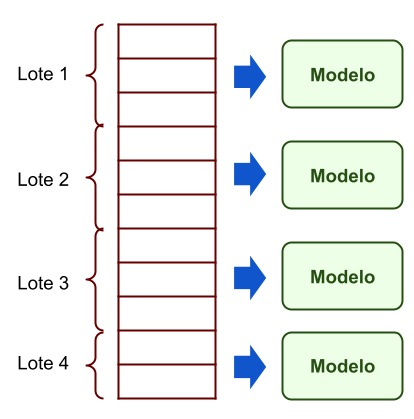


In [10]:
main_path = '/content/drive/MyDrive/DeepHistory/data/vox-png/train' #Cambiar la ruta de ser necesario
#test_path = '/content/drive/MyDrive/vox-png'
batch_index_path = '/content/drive/MyDrive/DeepHistory/logs'
fbatches='batches.txt'

In [5]:
def directory_iter(files, batch_size, shuffle=True):
  n = files.shape[0]
  
  if shuffle:
    indices = np.random.permutation(n)
  else:
    indices = range(n)

  for i in range(0, n, batch_size):
    batch_indices = indices[i:i+batch_size if i+batch_size <=n else n]
    #files_batch = files[batch_indices]
    yield batch_indices

Probaremos la implementación mostrando el tamaño de cada lote:

In [12]:
files=np.array(os.listdir(main_path))
batch_size = 5
total_samples = 0
mini_directory_bt=[]

if os.path.isfile(os.path.join(batch_index_path,fbatches)):
  os.remove(os.path.join(batch_index_path,fbatches))

with open(os.path.join(batch_index_path,fbatches), 'w') as f:
  for i, batch_indices in enumerate(directory_iter(files, batch_size), 1):
    total_samples += batch_indices.shape[0]
    #print(f'Lote {i} tiene tamaño {batch_indices.shape[0]}')
    for index in batch_indices:
      f.write("%s " % index)
    f.write("\n")

if total_samples == files.shape[0]:
  print(':) El número total de muestras por lotes es correcto.')
else:
  print(':( El número total de muestras por lotes difiere del total de muestras.')

:) El número total de muestras por lotes es correcto.


In [13]:
cd DeepHistory/

[Errno 2] No such file or directory: 'DeepHistory/'
/content/drive/MyDrive/DeepHistory


In [14]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [15]:
from shutil import copy
import imageio
import numpy as np
import sys
import uuid
import yaml
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
from time import gmtime, strftime
from skimage import img_as_ubyte
from ctypes import cdll
from train import train
from modules.generator import OcclusionAwareGenerator
from modules.discriminator import MultiScaleDiscriminator
from modules.keypoint_detector import KPDetector
from frames_dataset import FramesDataset,FramesDatasetPartitioning
from modules.util import DownBlock2d
from tqdm import trange
from torch.utils.data import DataLoader
from logger import Logger
from modules.model import GeneratorFullModel, DiscriminatorFullModel
from torch.optim.lr_scheduler import MultiStepLR
from sync_batchnorm import DataParallelWithCallback
from frames_dataset import DatasetRepeater
from demo import load_checkpoints, make_animation, load_checkpoints_Unet_3

In [16]:
batchf = './logs/batches.txt'
config = './config/prueba.yaml'

num_batch=4

batch_list=[]
with open(batchf, 'r') as f:
  for line in f.readlines():
    batch_list.append(list(map(int, line.rstrip().split(" "))))


with open(config) as f:
        config = yaml.load(f)

dataset = FramesDatasetPartitioning(is_train=1, **config['dataset_params'],batches_list=batch_list[num_batch])

Use predefined train-test split.
18061


In [18]:
print(batch_list[num_batch])
print(dataset.videos)

[12941, 15351, 13318, 6832, 4154]
['id10406#qyRPFNiPvJs#002398#003163.mp4'
 'id10130#rOyppZrYO0A#001866#002078.mp4'
 'id10231#PyZ7LqrciCs#001608#001708.mp4'
 'id10818#VaxjUkL42s4#000270#000459.mp4'
 'id10904#oHlsoMOOD1U#004815#004913.mp4']


In [19]:
warnings.filterwarnings("ignore")

config = './config/prueba.yaml'
device_ids = [0]
#checkpoint = './models/vox-adv-cpk.pth.tar'
checkpoint = None
log_dir = './logs'
batchf= './logs/batches.txt'

num_batch=4

batch_list=[]
with open(batchf, 'r') as f:
  for line in f.readlines():
    batch_list.append(list(map(int, line.rstrip().split(" "))))

if __name__ == "__main__":
    
    with open(config) as f:
        config = yaml.load(f)
        
    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'], **config['model_params']['common_params'])

    if torch.cuda.is_available():
        generator.to(device_ids[0])

    discriminator = MultiScaleDiscriminator(**config['model_params']['discriminator_params'], **config['model_params']['common_params'])

    if torch.cuda.is_available():
        discriminator.to(device_ids[0])

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'], **config['model_params']['common_params'])

    if torch.cuda.is_available():
        kp_detector.to(device_ids[0])
            
    dataset = FramesDatasetPartitioning(is_train=1, **config['dataset_params'],batches_list=batch_list[num_batch])

    print("Training...")

    train_params = config['train_params']

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=train_params['lr_generator'], betas=(0.5, 0.999))
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=train_params['lr_discriminator'], betas=(0.5, 0.999))
    optimizer_kp_detector = torch.optim.Adam(kp_detector.parameters(), lr=train_params['lr_kp_detector'], betas=(0.5, 0.999))

    if checkpoint is not None:
        start_epoch = load_cpk(checkpoint, generator, discriminator, kp_detector, optimizer_generator, optimizer_discriminator, None if train_params['lr_kp_detector'] == 0 else optimizer_kp_detector)
    else:
        start_epoch = 0

    scheduler_generator = MultiStepLR(optimizer_generator, train_params['epoch_milestones'], gamma=0.1, last_epoch=start_epoch - 1)

    scheduler_discriminator = MultiStepLR(optimizer_discriminator, train_params['epoch_milestones'], gamma=0.1, last_epoch=start_epoch - 1)

    scheduler_kp_detector = MultiStepLR(optimizer_kp_detector, train_params['epoch_milestones'], gamma=0.1, last_epoch=-1 + start_epoch * (train_params['lr_kp_detector'] != 0))

    if 'num_repeats' in train_params or train_params['num_repeats'] != 1:
        dataset = DatasetRepeater(dataset, train_params['num_repeats'])

    dataloader = DataLoader(dataset, batch_size=train_params['batch_size'], shuffle=True, num_workers=6, drop_last=True)

    generator_full = GeneratorFullModel(kp_detector, generator, discriminator, train_params)
    discriminator_full = DiscriminatorFullModel(kp_detector, generator, discriminator, train_params)

    if torch.cuda.is_available():
        generator_full = DataParallelWithCallback(generator_full, device_ids=device_ids)
        discriminator_full = DataParallelWithCallback(discriminator_full, device_ids=device_ids)

    with Logger(log_dir=log_dir, visualizer_params=config['visualizer_params'], checkpoint_freq=train_params['checkpoint_freq']) as logger:
        for epoch in trange(start_epoch, train_params['num_epochs']):
            for x in dataloader:
                #print(dataloader)
                losses_generator, generated = generator_full(x)

                loss_values = [val.mean() for val in losses_generator.values()]
                loss = sum(loss_values)

                loss.backward()
                optimizer_generator.step()
                optimizer_generator.zero_grad()
                optimizer_kp_detector.step()
                optimizer_kp_detector.zero_grad()

                if train_params['loss_weights']['generator_gan'] != 0:
                    optimizer_discriminator.zero_grad()
                    losses_discriminator = discriminator_full(x, generated)
                    loss_values = [val.mean() for val in losses_discriminator.values()]
                    loss = sum(loss_values)

                    loss.backward()
                    optimizer_discriminator.step()
                    optimizer_discriminator.zero_grad()
                else:
                    losses_discriminator = {}

                losses_generator.update(losses_discriminator)
                losses = {key: value.mean().detach().data.cpu().numpy() for key, value in losses_generator.items()}
                logger.log_iter(losses=losses)

            scheduler_generator.step()
            scheduler_discriminator.step()
            scheduler_kp_detector.step()
            
            logger.log_epoch(epoch, {'generator': generator, 'discriminator': discriminator, 'kp_detector': kp_detector, 'optimizer_generator': optimizer_generator, 'optimizer_discriminator': optimizer_discriminator, 'optimizer_kp_detector': optimizer_kp_detector}, inp=x, out=generated)

Use predefined train-test split.
18061
Training...


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 10/10 [41:34<00:00, 249.41s/it]
